In [93]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [133]:
from scipy.optimize import fmin_slsqp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from time import time
import os
import sys
from pathlib import Path
ROOT_PATH = Path().absolute().parent
if str(ROOT_PATH) not in sys.path:
    sys.path.insert(1, str(ROOT_PATH))
from frequency_response import FrequencyResponse
from biquad import peaking, digital_coeffs

In [3]:
fr = FrequencyResponse.read_from_csv(ROOT_PATH.joinpath('results', 'oratory1990', 'harman_over-ear_2018', 'Audeze LCD-4', 'Audeze LCD-4.csv'))

In [95]:
def print_filters(filters):
    print(', '.join([f'{fc:.0f} Hz' for fc in filters[:, 0]]))
    print(', '.join([f'{q:.2f} Q' for q in filters[:, 1]]))
    print(', '.join([f'{gain:.1f} dB' for gain in filters[:, 2]]))
    #for fc, q, gain in filters:
    #    print(f'{fc:.0f} Hz, {q:.3f} Q, {gain:.1f} dB')

In [437]:
def compare(fp, n):
    fr = FrequencyResponse.read_from_csv(fp)
    old_fbeq = fr.fixed_band_eq.copy()
    old_peq = fr.parametric_eq.copy()
    
    t = time()
    #fr.optimize_parametric_eq(max_filters=n)
    #fr.optimize_fixed_band_eq([31.25, 62.5, 125, 250, 500, 1000, 2000, 4000, 8000, 16000], [1.41] * 10, fs=48000)
    #fr.parametric_eq = fr.fixed_band_eq.copy()
    old_time = time() - t

    t = time()
    filters, n_filters, max_gains = fr.optimize_parametric_eq(n, fs=48000)
    #filters, n_filters, max_gain = fr.optimize_fixed_band_eq([31.25, 62.5, 125, 250, 500, 1000, 2000, 4000, 8000, 16000], 1.41, fs=48000)
    #fr.fixed_band_eq = fr.parametric_eq.copy()
    new_time = time() - t
    
    #fr.parametric_eq = old_peq

    ix = np.sum(fr.frequency < 10e3)
    new_rmse = np.sqrt(np.mean(np.square(fr.equalization[:ix] - fr.parametric_eq[:ix])))
    old_rmse = np.sqrt(np.mean(np.square(fr.equalization[:ix] - old_peq[:ix])))
    print(f'{fr.name}: RMSE {old_rmse:.2f} -> {new_rmse:.2f}  = {"+" if new_rmse > old_rmse else ""}{new_rmse - old_rmse:.2f} dB ({(new_rmse - old_rmse) / old_rmse * 100:.1f} %) @ {old_time*1000:.0f} -> {new_time*1000:.0f} ms')
    #fig, axs = plt.subplots(1, 2)
    #fig.set_size_inches(26, 8)
    #FrequencyResponse.init_plot(fig=fig, ax=axs[1])
    #fr.plot_graph(fig=fig, ax=axs[0], fixed_band_eq_plot_kwargs={'label': 'New optimizer'}, show=False)
    #for fc, q, gain in filters:
    #    axs[1].plot(fr.frequency, digital_coeffs(fr.frequency, 48e3, *peaking(fc, q, gain, fs=48e3), reduce=True), label=f'{fc:.0f} Hz, {q:.3f} Q, {gain:.1f} dB')
    #axs[1].legend()
    #axs[1].set_title('Filters')
    #plt.show()

In [439]:
n = [5, 5]
i = 1
for fp in ROOT_PATH.joinpath('results', 'oratory1990').glob('*/*/*.csv'):
    compare(fp, n)
    i += 1
    if i > 10:
        break

1MORE Quad Driver: RMSE 0.42 -> 0.19  = -0.23 dB (-55.3 %) @ 0 -> 630 ms
1MORE Single Driver: RMSE 0.33 -> 0.47  = +0.15 dB (45.2 %) @ 0 -> 457 ms
1MORE Triple Driver LTNG: RMSE 0.52 -> 0.48  = -0.04 dB (-7.8 %) @ 0 -> 625 ms
64 Audio A12t (m15 Apex module): RMSE 0.48 -> 0.29  = -0.19 dB (-39.3 %) @ 0 -> 636 ms
64 Audio A12t (m20 Apex module): RMSE 0.55 -> 0.38  = -0.18 dB (-32.0 %) @ 0 -> 631 ms
64 Audio N8: RMSE 0.35 -> 0.45  = +0.10 dB (29.5 %) @ 0 -> 423 ms
7Hz Timeless: RMSE 0.51 -> 0.16  = -0.35 dB (-67.9 %) @ 0 -> 411 ms
AKG K3003: RMSE 0.34 -> 0.21  = -0.13 dB (-39.2 %) @ 0 -> 484 ms
AKG N20: RMSE 0.24 -> 0.22  = -0.02 dB (-7.6 %) @ 0 -> 577 ms
AKG N400: RMSE 0.25 -> 0.13  = -0.13 dB (-49.8 %) @ 0 -> 513 ms


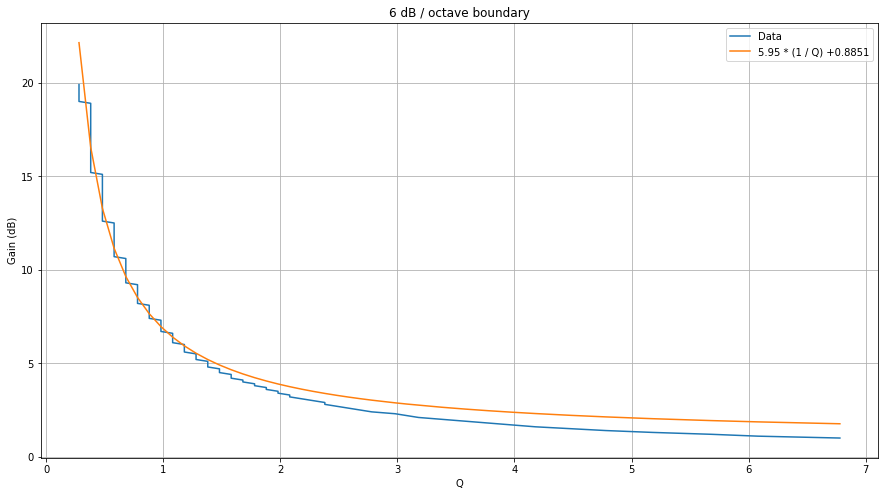

0.8851201297273104 + 5.951901011156011 x**1


In [426]:
fc = 20 * 2**(np.log(20e3 / 20) / np.log(2) / 2)
q = np.arange(0.18, 9, 0.1)
gain = np.arange(1, 20, 0.1)
f = FrequencyResponse.generate_frequencies()
f_step = np.log(f[1] / f[0]) / np.log(2)
max_d = []
for g in gain:
    frs = digital_coeffs(fr.frequency, 48e3, *peaking(fc, q, g, fs=48000))
    max_d.append([(np.max(fr[1:-1] - np.roll(fr, 1)[1:-1]) / f_step) for fr in frs])
max_d = np.array(max_d)
q, gain = np.meshgrid(q, gain)

d_threshold = 6
qs = []
for row in max_d:
    ix = min(np.sum(row < d_threshold), max_d.shape[1] - 1)
    qs.append(q[0, ix])
qs = np.array(qs)
    
ix0 = np.sum(qs == 9.0)
p = np.polynomial.Polynomial.fit(1 / qs[ix0:], gain[ix0:, 0], 1)
p = p.convert()
est = p(1 / qs[ix0:])
    
fig, ax = plt.subplots()
fig.set_size_inches(15, 8)
ax.plot(qs[ix0:], gain[ix0:, 0], label='Data')
ax.plot(qs[ix0:], est, label=f'{p.coef[1]:.2f} * (1 / Q) {"+" if p.coef[0] >= 0 else "-"}{np.abs(p.coef[0]):.4f}')
ax.grid()
ax.set_ylabel('Gain (dB)')
ax.set_xlabel('Q')
ax.legend()
ax.set_title(f'{d_threshold} dB / octave boundary')
plt.show()
print(p)

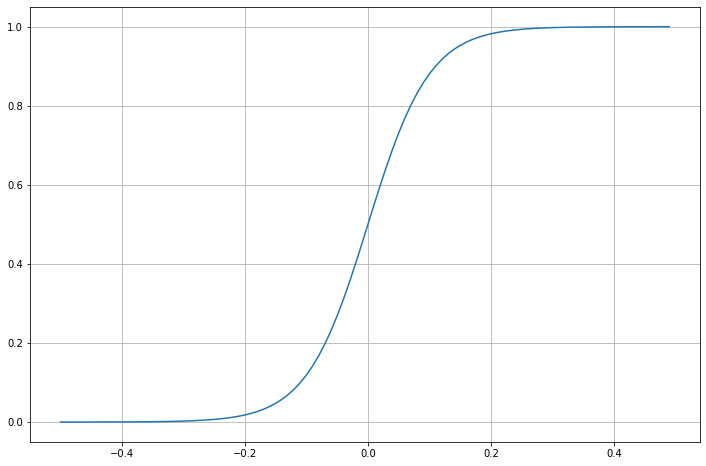

In [421]:
x = np.arange(-0.5, 0.5, 0.01)
fig, ax = plt.subplots()
fig.set_size_inches(12, 8)
plt.plot(x, 1 / (1 + np.e**(-x * 20)))
plt.grid()

In [429]:
FrequencyResponse._sharpness_penalty(np.array([3, 6, 5.2]), np.array([8, 3.3, 3.5]))

array([[0.97483799],
       [0.44895691],
       [0.13315128]])